In [1]:
import glob
import os
import numpy as np

In [2]:
import matplotlib.pyplot as plt

/Users/VyUng/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import math

In [4]:
def processing_data(path):
    get_files=glob.glob(os.path.join(os.getcwd(), path))
    result=[]
    for file_path in get_files :
        with open(file_path) as f_input:
            result.append(f_input.read())
    return result
train_data = processing_data("symbol/language-training*")
test_data = processing_data("symbol/language-test*")

In [5]:
language_A=processing_data("symbol/language-training-langA*")
language_B=processing_data("symbol/language-training-langB*")
language_C=processing_data("symbol/language-training-langC*")

In [6]:
letters=['A','o','e','t','p','g','k']
def transition_matrix(language):
    table=np.zeros((7,7))
    for string in language:
        for index in range(len(string)-1):
            for i in range(len(letters)):
                if string[index]==letters[i]:
                    for j in range(len(letters)):
                        if string[index+1]==letters[j]:
                            table[i][j]+=1
    table=table/table.sum(axis=1)[:,None]
    return table


In [7]:
table_A=transition_matrix(language_A)
table_B=transition_matrix(language_B)
table_C=transition_matrix(language_C)

In [8]:
def get_likelihood(table, test_string):
    log_likelihood=0
    for index in range(len(test_string)-1):
        for i in range(len(letters)):
            if test_string[index]==letters[i]:
                for j in range(len(letters)):
                    if test_string[index+1]==letters[j]:
                        if table[i][j]==0:
                            return 0
                        else:
                            log_likelihood+=math.log(table[i][j])
    likelihood=math.exp(log_likelihood)
    return likelihood

In [9]:
def classifier(test_set,table_A,table_B,table_C):
    posteriors=[]
    for string in test_set:
        lA=get_likelihood(table_A, string)
        lB=get_likelihood(table_B, string)
        lC=get_likelihood(table_C, string)
        evidence=lA+lB+lC
        this_posterior=[lA/evidence,lB/evidence,lC/evidence]
        posteriors.append(this_posterior)
    return posteriors
        

In [10]:
print classifier(test_data,table_A,table_B,table_C)

[[5.256563173673339e-61, 0.0, 1.0], [4.627742576668604e-68, 0.0, 1.0], [1.0, 0.0, 1.012551150199641e-34], [3.361094457359881e-46, 1.0, 6.176188211356044e-59], [1.0, 0.0, 1.3215362632439907e-46], [1.0, 0.0, 1.1527411981126842e-39], [2.646315875864538e-63, 1.0, 4.049763080752548e-62], [1.0, 0.0, 7.480114916700446e-42], [2.2198377249617136e-81, 0.0, 1.0], [1.0, 0.0, 1.024382283460967e-46]]


In [11]:
with open("speaker.txt",'r')as doc:
    string=doc.read()
print string

eoggeggAeggepgpppoppogopppgoppoopegAAoAAAtAtttooepooppteeeeotpopppeeoepooopopgoooepoepotpoegogggggkeggpogopopeAtAttAoApAtttAggeAgegettttAAAAtoeeggeteoAopopotoktttpoepegpgtgAgAeeppeoooopgeggpAAAAgAtgegogoeepAtAtAAotAAAtttAtkAAAtAAktAAAtttAtAAoAtteeoopoAoAtoAAtAAApgeoeeeeoeeegteoAopeAkopgpeAgetAeeotAttAAeAAktttkAptAetAttAkAAAttAAkAAAttAAAAgAgkgogppgooApkpoAopopptotegoAppppAgettgtteAtttAAttAtpoooopopkeogeeettgtAAttAtAtttpopptoAokpopooooAooeoopopptoopgpAAootAtgtpgeeeeegegeAkeAgtoAoAooepgeegegeegekeegtoAAttttttggeegkeegggetgggggeggegeAgpoooktoppoopApoooAtAeAgegegoegeAgpeotppogpoppppoppoppoootAtAAAtApopoopooooopopppopoppoottoopopookAtAAAtettApAtttooAAtteeoAttppeAgtpeegoeeAtoAteeAeeppopekotktetppgpkgktopAAtkkgegttAAtoopopkeAApgoAotteegegeogkoggpAggpkAgAttttAAtAttAteeeopoetAttAtkeoAopgtAtktgtgttopooppgopppppppopeooAptoopopAookApoggtpttttoAoppoopAppoAoppooppptpAooppppppoooAAAtttttttAtteegggeeoeegeoeggkettkAAoAkAAteeggggkAgAtpAAAttAtAAAptAeppAAAopppAApkeeokpeegpppekpegeeeteoopoApoookoogggegekopo

In [12]:
def expectation(letters,text,emission_table,transition_table,prior):
    posteriors=np.empty([1000, 3])
    for index in range(len(text)):
        for i in range(len(letters)):
            if text[index]==letters[i]:
                likelihood=emission_table[:,i]
                posterior=(likelihood*prior)/(sum(likelihood*prior))
                for k in range(2):
                    prior[k]=sum(posterior*transition_table[:,k])
                posteriors[index]=posterior
    return posteriors


In [37]:
def maximization(post,string,letters):
    num_speaker=3
    num_letter=7
    e_matrix=np.empty([num_speaker,num_letter])
    t_matrix=np.empty([num_speaker,num_speaker])
    for s_index in range(len(string)):
        for person in range(num_speaker):
            for l_index in range(len(letters)):
                if string[s_index]==letters[l_index]:
                    e_matrix[person,l_index]+=post[s_index,person]
    e_matrix=e_matrix/(e_matrix.sum(axis=1)[:,None])
    for before in range(num_speaker):
        for after in range(num_speaker):
            for pos in range(len(post)-1):
                t_matrix[before,after]+=post[pos,before]*post[pos+1,after]
    t_matrix=t_matrix/(t_matrix.sum(axis=0,keepdims=1))
    return (e_matrix,t_matrix)    

In [48]:
np.random.seed(0)
row1=np.random.dirichlet(np.ones(7),size=1)
row2=np.random.dirichlet(np.ones(7),size=1)
row3=np.random.dirichlet(np.ones(7),size=1)
emission_table=np.concatenate((row1,row2,row3))
transition_table=np.array([[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.05,0.9]])
prior=np.array([1/float(3),1/float(3),1/float(3)])
num_iters=1000
for i in range(num_iters):
    new_pos=expectation(letters,string,emission_table,transition_table,prior)
    emission_table=maximization(new_pos,string,letters)[0]
    transition_table=maximization(new_pos,string,letters)[1]
print new_pos

[[  1.00000000e+00   2.16365370e-70   8.04415481e-79]
 [  3.66431377e-01   3.49947145e-10   6.33568623e-01]
 [  1.00000000e+00   1.49921241e-58   5.38462770e-74]
 ..., 
 [  2.91691122e-01   4.76204362e-10   7.08308877e-01]
 [  8.99025015e-08   3.58554779e-47   9.99999910e-01]
 [  7.16186484e-02   1.65745648e-10   9.28381351e-01]]


In [53]:
ps=[]
ls=[]
for i in range(len(new_pos)):
    this_p=np.argmax(new_pos[i])+1
    ps.append(this_p)
    ls.append(string[i])
    #print "Person",this_p,"spoke letter", string[i]

In [50]:
import pandas as pd
df=pd.DataFrame({'Speaker':ps, 'Phoneme':ls})
totals=pd.crosstab(df['Speaker'],df['Phoneme'],margins=True).reset_index()
print totals

Phoneme Speaker    A    e    g   k    o    p    t   All
0             1    0  141  121  24    0    0    0   286
1             2  176    0    0  15    0    0  168   359
2             3    0    0    0   0  188  167    0   355
3           All  176  141  121  39  188  167  168  1000


In [51]:
plot_pos=new_pos
plot_pos=np.transpose(plot_pos)

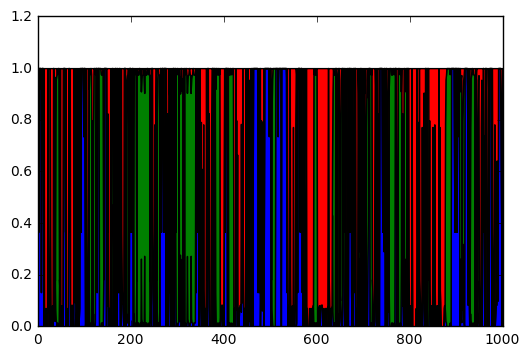

In [52]:
fig, ax = plt.subplots()
ax.stackplot(np.arange(1000), plot_pos)
plt.show()